## 📝 Predicting Hight Traffic Recipes

Project Steps:

- Data Validation:   
  - Describes validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Includes two different graphics that demonstrates the characteristics of data  
  - Includes two graphs that demonstrate the relationship between features
  - Describes the findings
- Model Development
  - Includes the reasons for selecting the models we use as well as a statement of the problem type
  - Codes to fit the baseline and comparison models
- Model Evaluation
  - Describes the performance of the two models based on an appropriate metric
- Business Metrics
  - Defines a way to compare our model performance to the business goal.
  - Describes how our models perform using this approach
- Final summary including recommendations that the business should undertake

In [1185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1186]:
recipe_data = pd.read_csv('recipe_site_traffic_2212.csv')

recipe_data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


**DATA VALIDATION**

In [1187]:
recipe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [1188]:
recipe_data.set_index('recipe', inplace=True)

In [1189]:
recipe_data['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [1190]:
recipe_data['category'] = recipe_data['category'].replace('Chicken Breast', 'Chicken')
recipe_data['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

In [1191]:
recipe_data['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [1192]:
recipe_data['servings'] = recipe_data['servings'].replace({'4 as a snack': '4', '6 as a snack': '6'})
recipe_data['servings'] = recipe_data['servings'].astype(int)
recipe_data['servings'].value_counts()


4    391
6    198
2    183
1    175
Name: servings, dtype: int64

In [1193]:
missing_proportion = recipe_data.isnull().mean() * 100
print(missing_proportion)

calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64


In [1194]:
recipe_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 59.2+ KB


'high_traffic Character, if the traffic to the site was high when this recipe was shown, this is marked with “High”.'


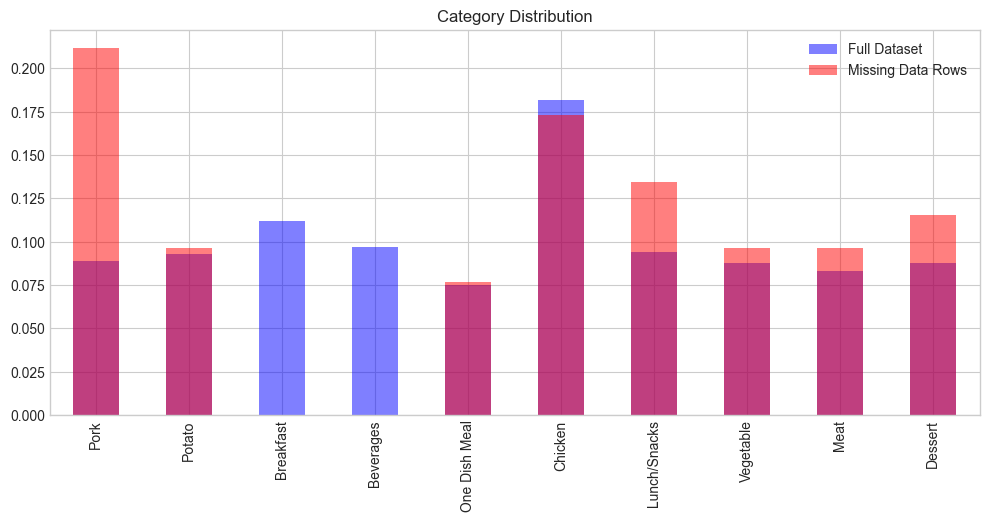

In [1195]:
full_data_dist = recipe_data['category'].value_counts(normalize=True)
missing_data_dist = missing_rows['category'].value_counts(normalize=True)

# Ensuring both distributions have the same categories
all_categories = recipe_data['category'].unique()
full_data_dist = full_data_dist.reindex(all_categories, fill_value=0)
missing_data_dist = missing_data_dist.reindex(all_categories, fill_value=0)

plt.figure(figsize=(12, 5))
full_data_dist.plot(kind='bar', color='blue', alpha=0.5, label='Full Dataset')
missing_data_dist.plot(kind='bar', color='red', alpha=0.5, label='Missing Data Rows')
plt.title('Category Distribution')
plt.legend()
plt.show()


In [1196]:
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# Impute missing values based on the mean of their category
for col in numeric_columns:
    recipe_data[col] = recipe_data.groupby(['category', 'servings'])[col].transform(lambda x: x.fillna(x.mean()))

recipe_data['high_traffic'].fillna('Low', inplace=True)
recipe_data.dropna(subset=numeric_columns, inplace=True)
cleaned_data = recipe_data.isna().sum()
print(cleaned_data)

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


**EXPLORATORY DATA ANALYSIS**

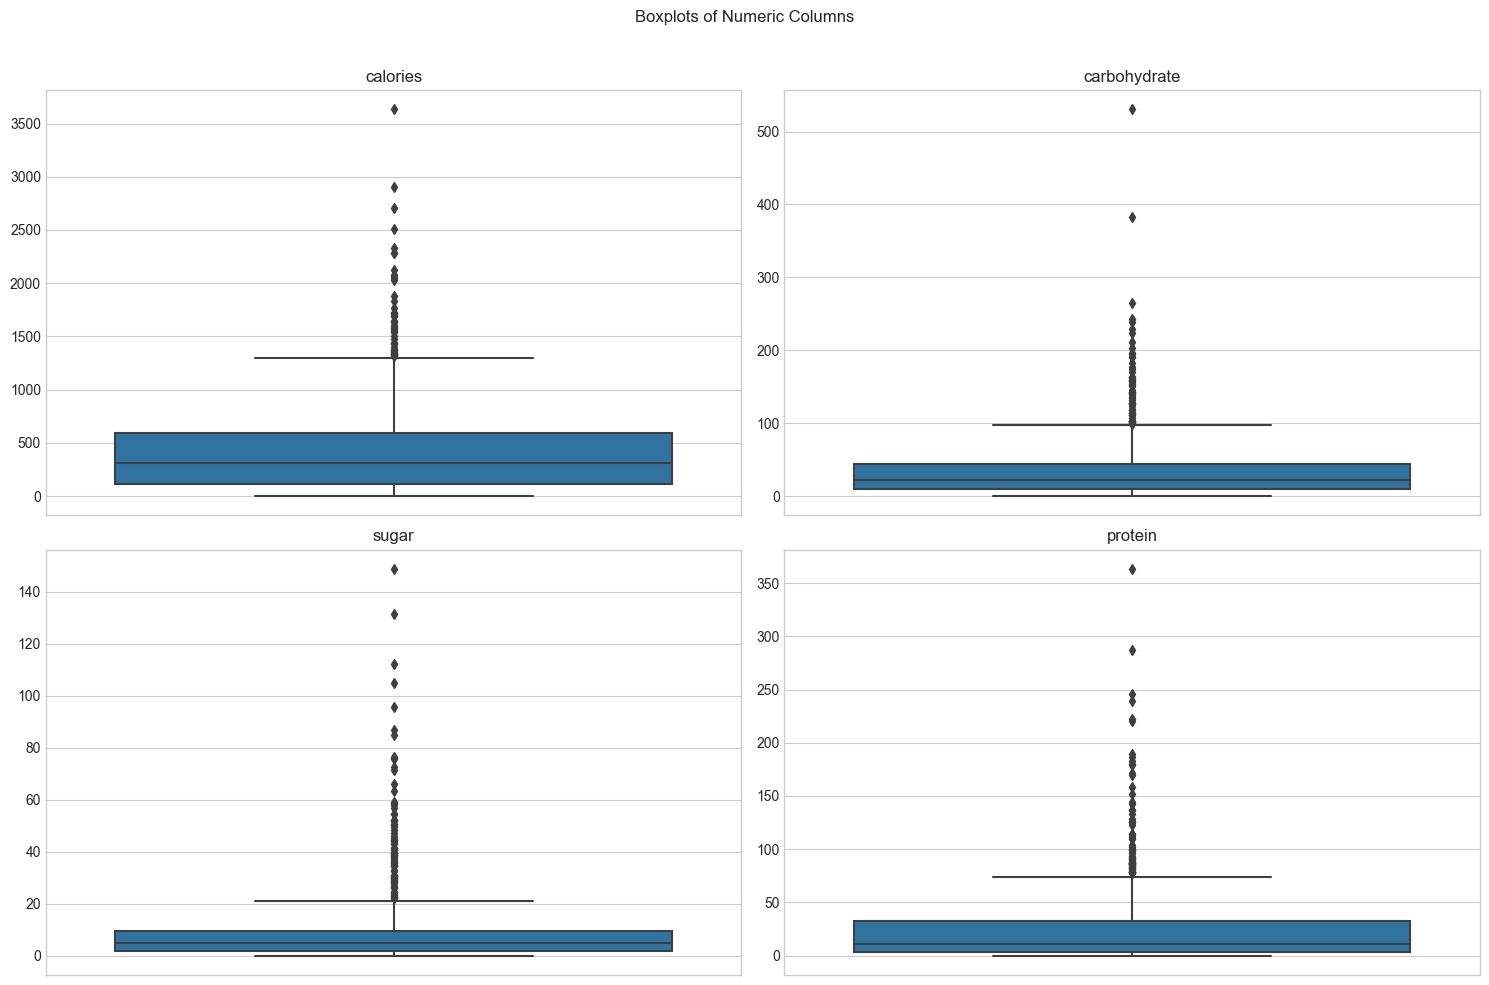

In [1197]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Boxplots of Numeric Columns')

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each numeric column's distribution as a boxplot on one of the subplots
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=recipe_data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()


In [1198]:
exclude_columns = 'high_traffic'

for col in numeric_columns:
    Q1 = recipe_data[col].quantile(0.25)
    Q3 = recipe_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = recipe_data[(recipe_data[col] < (Q1 - 1.5 * IQR)) | (recipe_data[col] > (Q3 + 1.5 * IQR))]
    outliers_display = outliers.drop(columns=exclude_columns)
    outliers_sorted = outliers_display.sort_values(by=col, ascending=False)  # Sort the outliers in descending order
    print(f'Potential outliers for {col}:\n', outliers_sorted)


Potential outliers for calories:
         calories  carbohydrate  sugar  protein       category  servings
recipe                                                                 
926      3633.16         29.07   0.35     2.32        Chicken         4
125      2906.01          3.52   1.89   179.22           Pork         6
227      2703.12          6.40   2.17    28.20           Pork         6
72       2508.47         18.11  10.60    84.23        Chicken         4
908      2332.32          7.47   3.62    34.33  One Dish Meal         1
940      2283.29         34.34   5.12    17.57        Chicken         6
357      2282.60          4.50   4.16    31.19  One Dish Meal         4
56       2122.24         25.99   0.52    81.37           Pork         1
98       2081.69          8.09   4.78    28.48  One Dish Meal         2
782      2068.07         34.23   1.46    10.02         Potato         1
398      2051.34          2.46   2.12    69.62        Chicken         2
637      2029.33         25.08

In [1199]:
suspicious_otliers = [926, 451, 350, 739, 682, 696, 343, 168, 454, 694, 22, 343, 541, 576, 762, 368, 262, 541, 816]  

recipe_data = recipe_data.drop(suspicious_otliers)

invalid_rows = (recipe_data['protein'] > recipe_data['calories']) | \
               (recipe_data['carbohydrate'] > recipe_data['calories']) | \
               (recipe_data['sugar'] > recipe_data['calories'])

print(f"Number of invalid rows: {invalid_rows.sum()}")
print(f"Total rows before removal: {len(recipe_data)}")

# Drop the invalid rows
recipe_data = recipe_data[~invalid_rows]

print(f"Total rows after removal: {len(recipe_data)}")


Number of invalid rows: 88
Total rows before removal: 930
Total rows after removal: 842


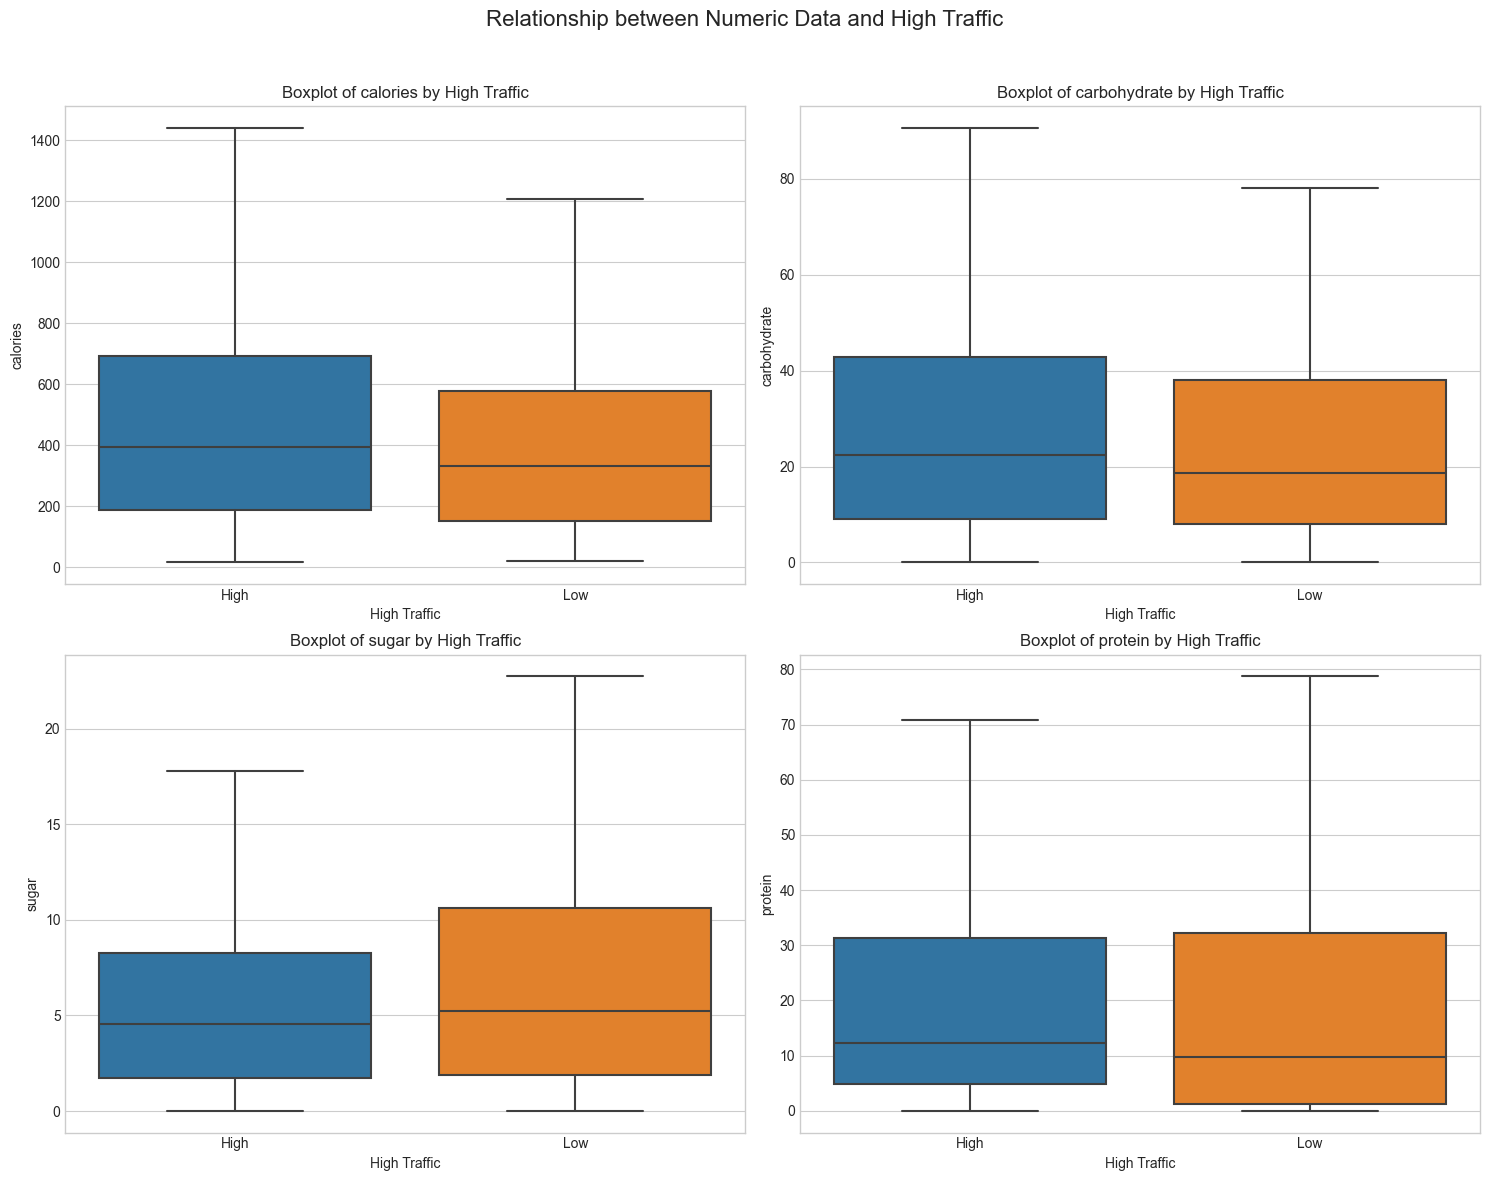

In [1204]:
# Set up the 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationship between Numeric Data and High Traffic', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x='high_traffic', y=col, data=recipe_data, ax=axes[i], showfliers=False)
    
    axes[i].set_title(f'Boxplot of {col} by High Traffic')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('High Traffic')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()





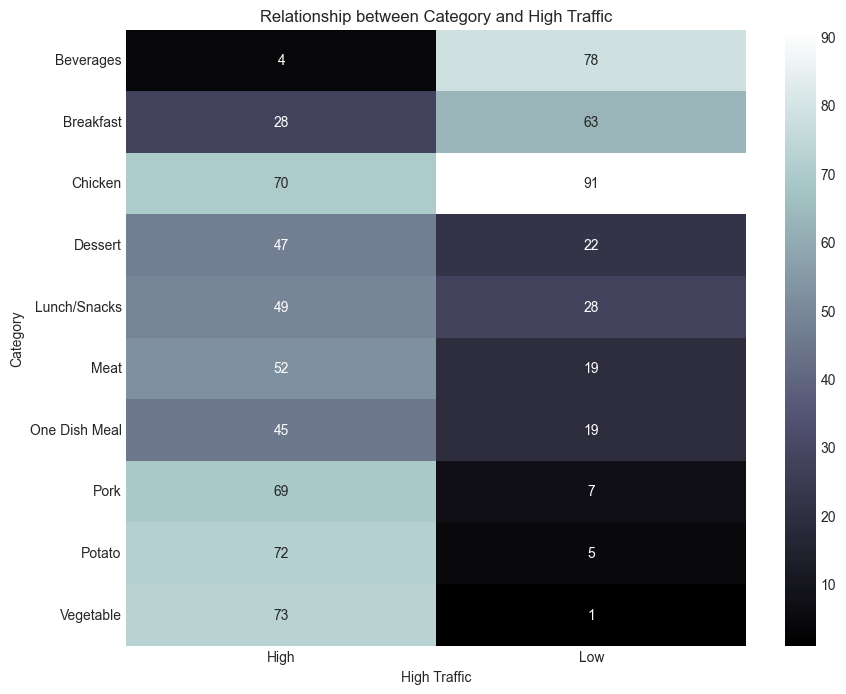

In [1201]:
# Create a crosstab of the category and high_traffic columns
ct = pd.crosstab(recipe_data['category'], recipe_data['high_traffic'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ct, annot=True, cmap='bone', cbar=True, fmt="d") 
plt.title('Relationship between Category and High Traffic')
plt.xlabel('High Traffic')
plt.ylabel('Category')
plt.show()


**MODEL PRE-PROCESSING**


In [1202]:
recipe_data['servings'].value_counts()

4    346
6    175
2    165
1    156
Name: servings, dtype: int64

In [1175]:

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Distribution of Numeric Columns')

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(recipe_data[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()

KeyboardInterrupt: 

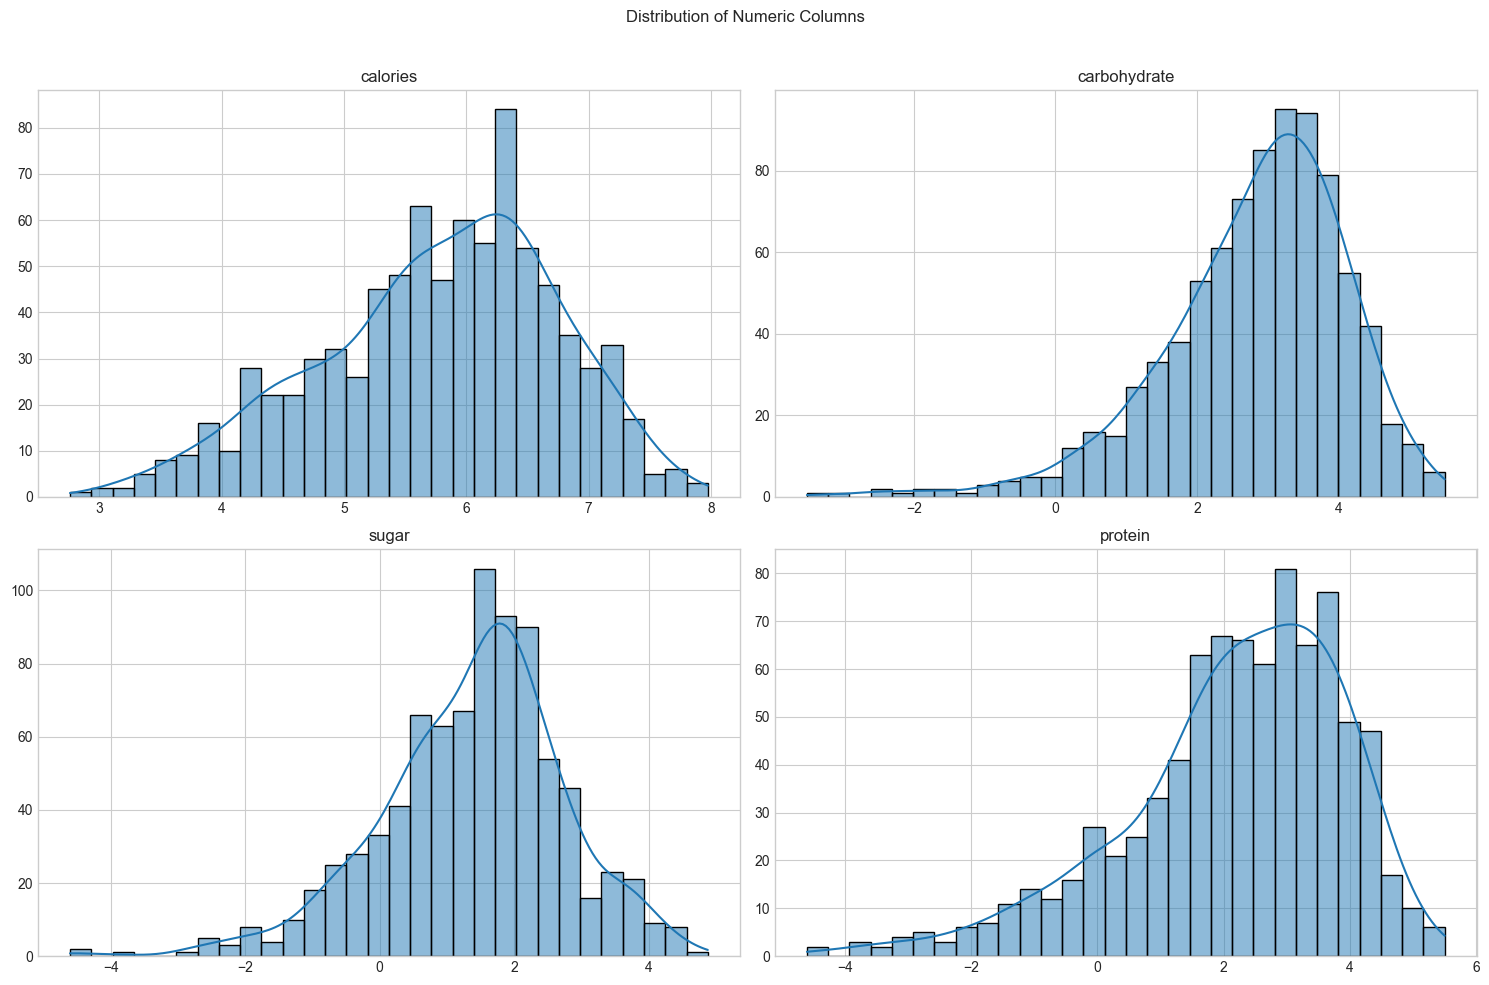

In [1176]:
recipe_data[numeric_columns] = np.log(recipe_data[numeric_columns])

f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('Distribution of Numeric Columns')

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(recipe_data[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title position
plt.show()

In [1177]:
recipe_data.replace([np.inf, -np.inf], np.nan, inplace=True)
recipe_data.dropna(subset=numeric_columns, inplace=True)

In [1178]:
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# One-hot encoding the category column
recipe_data_processed = pd.get_dummies(recipe_data, columns=['category'], prefix='', prefix_sep='')
# Label encoding the high_traffic column
le = LabelEncoder()
recipe_data_processed['high_traffic'] = le.fit_transform(recipe_data_processed['high_traffic'])
print(recipe_data_processed.columns)
# Splitting into features and target
X = recipe_data_processed.drop(columns=['high_traffic'])  
y = recipe_data_processed['high_traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Scaling the numeric columns
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns]) 
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])




Index(['calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       'high_traffic', 'Beverages', 'Breakfast', 'Chicken', 'Dessert',
       'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'],
      dtype='object')


**Logistic Regression**

In [1179]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initializing the model and grid search
logreg_cv = LogisticRegression(max_iter=1000, penalty = 'l2')
grid_search = GridSearchCV(logreg_cv, param_grid, cv=5, scoring='precision')

# Fit the model
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

Best Parameters: {'solver': 'liblinear'}
Best Cross-validation Score: 0.6865


In [1180]:
logreg = LogisticRegression(max_iter = 1000, penalty='l2', solver=grid_search.best_params_['solver'])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Calculate the precision score
prec_score = precision_score(y_test, y_pred)

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7581


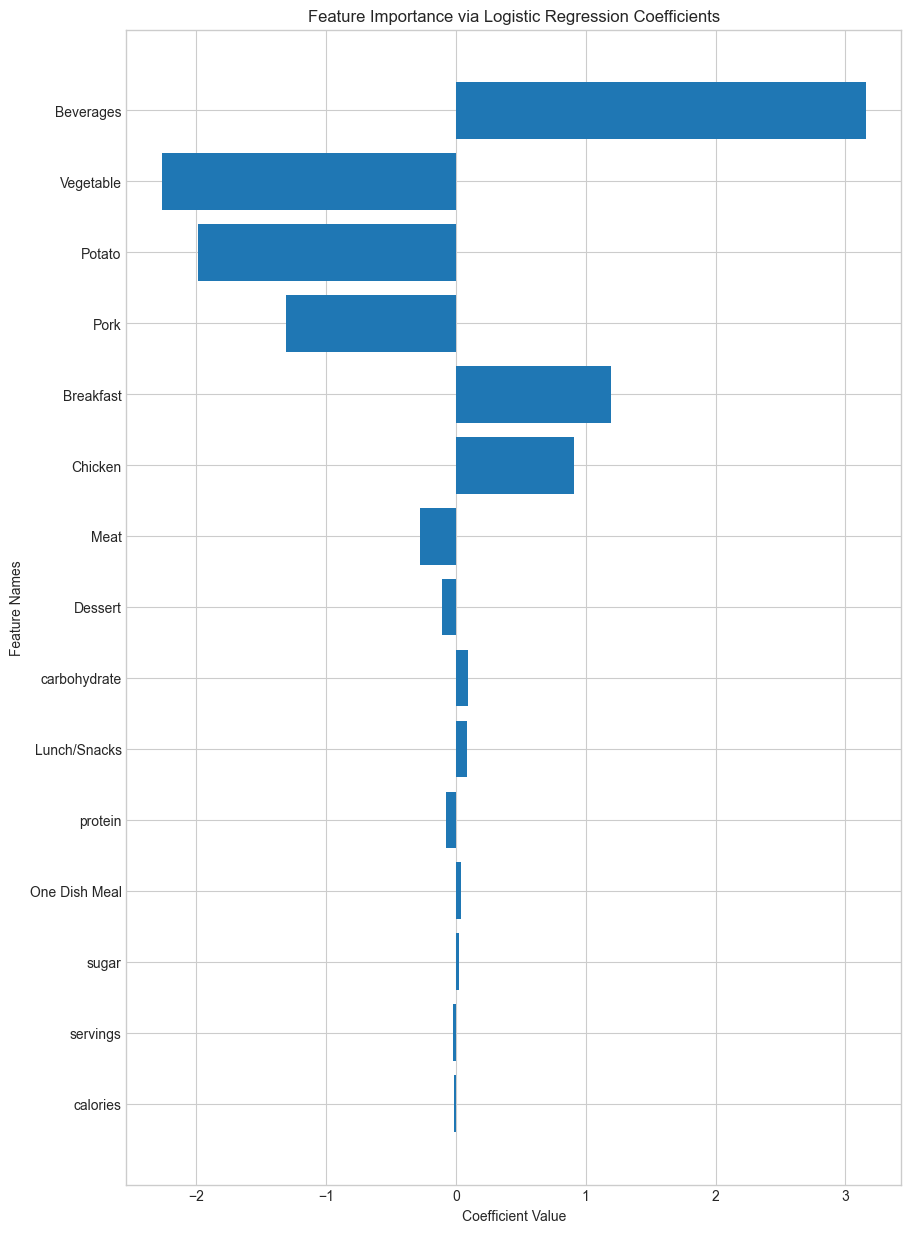

In [1181]:

feature_names = X_train.columns
coefficients = logreg.coef_[0]

# Pair them up in a tuple and sort by coefficient value
feature_importance = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Separate the tuples for plotting
features, coeffs = zip(*feature_importance)

# Plot
plt.figure(figsize=(10, 15))
# Reverse the order for plotting
plt.barh(features[::-1], coeffs[::-1])
plt.title('Feature Importance via Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.show()

In [1182]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

# Train KNN with the best hyperparameters
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

# Calculate the precision score
prec_score = precision_score(y_test, y_pred)
print(f"Precision Score: {prec_score:.4f}")



Best Parameters: {'metric': 'euclidean', 'n_neighbors': 24, 'weights': 'uniform'}
Best Cross-validation Score: 0.7501
Precision Score: 0.6471


In [1152]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.9],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

# Setup GridSearchCV optimized for precision
grid_search = GridSearchCV(gb_model, param_grid, scoring='precision', cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [1153]:
final_model = GradientBoostingClassifier(**grid_search.best_params_)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

final_precision = precision_score(y_test, y_pred_final)

print("Final Model Precision:", final_precision)

Final Model Precision: 0.85


In [1122]:
from sklearn.utils import resample

# The final model configuration
precision_scores_bootstrap = []

# Number of iterations
n_iterations = 1000

# Size for each sampled dataset
n_size = int(len(X_train) + len(X_test))

for i in range(n_iterations):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X, y, n_samples=n_size)
    
    # Split into train and test sets
    X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)
    
    # Train and evaluate the model
    final_model.fit(X_train_resampled, y_train_resampled)
    y_pred = final_model.predict(X_test_resampled)
    
    prec = precision_score(y_test_resampled, y_pred)
    precision_scores_bootstrap.append(prec)

# Checking the percentage of precision scores above 80%
above_80 = sum([1 for x in precision_scores_bootstrap if x >= 0.8]) / n_iterations

print(f"Percentage of iterations with precision >= 80%: {above_80*100:.2f}%")


KeyboardInterrupt: 

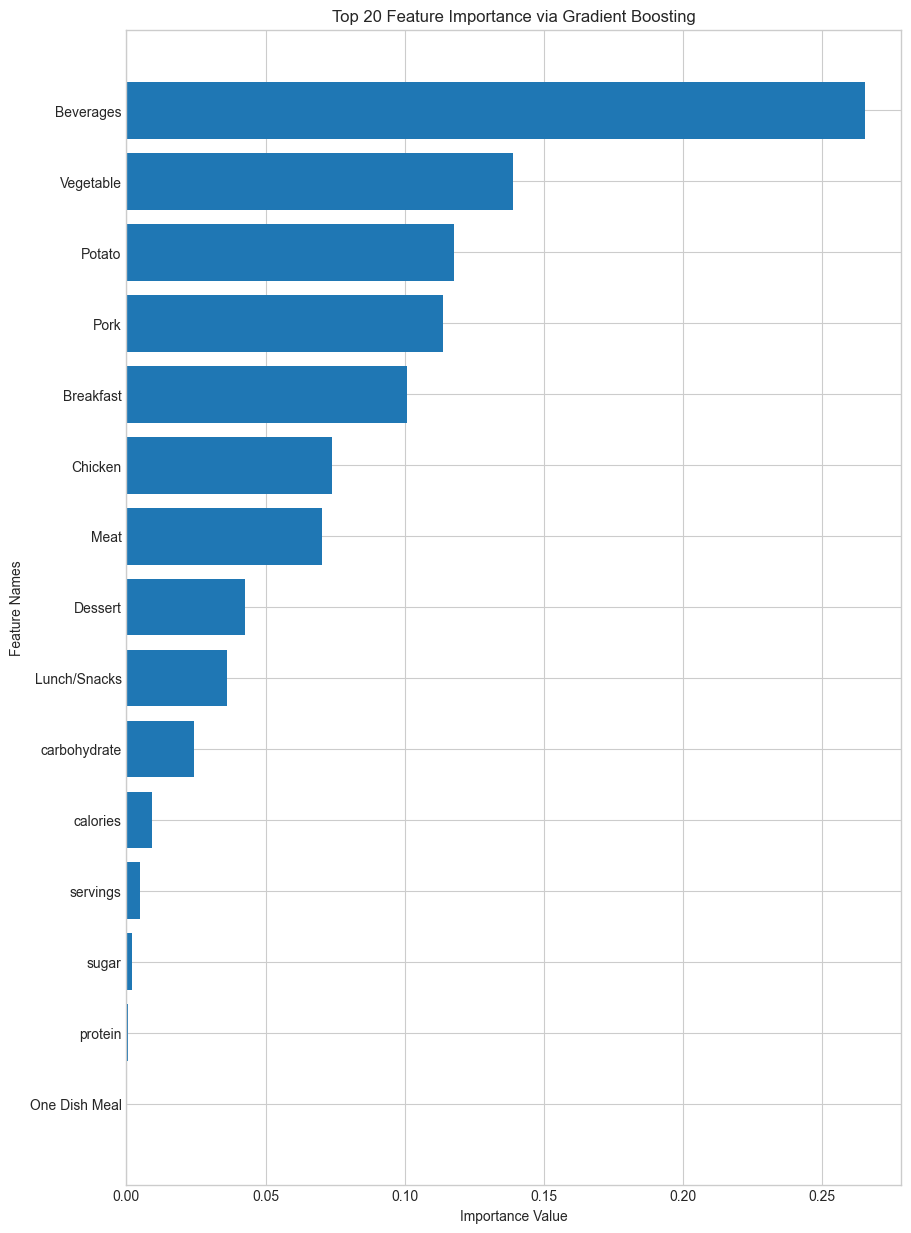

In [1123]:
feature_importances = final_model.feature_importances_

# Pair them up in a tuple and sort by importance value
sorted_importance = sorted(list(zip(feature_names, feature_importances)), key=lambda x: x[1], reverse=True)

top_features, top_importances = features[:20], importances[:20]

plt.figure(figsize=(10, 15))
plt.barh(top_features, top_importances)
plt.title('Top 20 Feature Importance via Gradient Boosting')
plt.xlabel('Importance Value')
plt.ylabel('Feature Names')
plt.gca().invert_yaxis()  
plt.show()


**MODEL EVALUATION**

**BUSINESS METRICS**

**FINAL SUMMARY**

Need to check the data. Many suspicious cases

Check the feature importance of logistic regression and Gradient boosting tree.